In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def read_gtfs_files():
    """
    Reads necessary GTFS static files and returns them as DataFrames.
    """
    routes_df = pd.read_csv('GTFS-Static-Data/routes.txt')
    trips_df = pd.read_csv('GTFS-Static-Data/trips.txt')
    stops_df = pd.read_csv('GTFS-Static-Data/stops.txt')
    stop_times_df = pd.read_csv('GTFS-Static-Data/stop_times.txt')
    calendar_df = pd.read_csv('GTFS-Static-Data/calendar.txt')
    return routes_df, trips_df, stops_df, stop_times_df, calendar_df

In [3]:
def filter_by_route(routes_df, route_short_name='145'):
    """
    Filters routes by short name and returns the route ID.
    """
    bus_route_id = routes_df[routes_df['route_short_name'] == route_short_name]['route_id'].iloc[0]
    return bus_route_id

In [4]:
def filter_by_stop(stops_df, stop_name):
    sfu_stop_id = stops_df[stops_df['stop_name'].str.contains(stop_name, case=False, na=False)]['stop_id'].iloc[0]
    return sfu_stop_id

In [5]:
def filter_trips_to_SFU_by_route(trips_df, route_id, direction_id):
    """
    Filters trips by route ID.
    direction_id = 0 -> Production Way to SFU, direction_id = 1 -> SFU to Production Way
    """
    return trips_df[(trips_df['route_id'] == route_id) &
                   (direction_id == direction_id)]

In [6]:
def filter_stop_times_by_trip_and_stop(stop_times_df, trip_to_SFU_df, stop_id):
    """
    Filters stop times by trip ID and stop ID.
    """
    merged_df = pd.merge(stop_times_df, trip_to_SFU_df, on='trip_id')
    filtered_df = merged_df[merged_df['stop_id']==stop_id]
    return filtered_df

In [7]:
def get_trips_by_day(df,calendar_df, day_name):
    """
    Filter trips by day.
    
    :param df: DataFrame containing the trip data
    :param day_name: Name of the day to filter by (e.g., 'Monday')
    :return: DataFrame with trips that run on the specified day
    """
    trip_at_SFU_service = pd.merge(df, calendar_df, on='service_id')
    filtered_trip = trip_at_SFU_service[trip_at_SFU_service[day_name]==1]
    selected_columns = ['trip_id', 'arrival_time', day_name]
    filtered_trip = filtered_trip[selected_columns]
    filtered_trip= filtered_trip.sort_values(by='arrival_time')
    filtered_trip = filtered_trip.reset_index(drop=True)
    return filtered_trip

In [8]:
def convert_time(time_str):
        """Converts time strings into timedelta, adjusting for times beyond 24:00:00."""
        hours, minutes, seconds = map(int, time_str.split(':'))
        if hours >= 24:
            hours -= 24  # Adjust hours to 0-23 range
            # Add one day to the timedelta for times past 24:00:00
            return pd.Timedelta(days=1) + pd.Timedelta(hours=hours, minutes=minutes, seconds=seconds)
        else:
            return pd.Timedelta(hours=hours, minutes=minutes, seconds=seconds)

In [9]:
def calculate_time_diff_and_period(df):
    """
    Calculates time differences between consecutive buses and assigns period based on arrival time.
    This function is a placeholder to illustrate where you'd calculate 'Time Diff' and 'Period'.
    """
    df['timedelta'] = df['arrival_time'].apply(convert_time)

    # Calculate the time difference in minutes
    df['time_diff'] = df['timedelta'].diff().dt.total_seconds() / 60
    df['time_diff'].fillna(0, inplace=True) 
    
    # Apply 'classify_period' to each row for the 'period' column
    df['period'] = df['timedelta'].apply(classify_period)
    
    # Remove the 'timedelta' column it's no longer needed
    df.drop('timedelta', axis=1, inplace=True)
    
    return df

In [10]:
# Updated Define periods function to match new criteria
def classify_period(time):
    if pd.Timedelta(hours=5) <= time < pd.Timedelta(hours=11):
        return 'Morning'
    elif pd.Timedelta(hours=11) <= time < pd.Timedelta(hours=16):
        return 'Afternoon'
    elif pd.Timedelta(hours=16) <= time < pd.Timedelta(hours=21):
        return 'Evening'
    elif (pd.Timedelta(hours=21) <= time) or (time < pd.Timedelta(hours=2)):
        return 'Night'

In [13]:
def main():
    routes_df, trips_df, stops_df, stop_times_df, calendar_df = read_gtfs_files()
    
    # get bus route_id and stop sfu transit bay 2
    route_id = filter_by_route(routes_df, '144')
    sfu_stop_id = filter_by_stop(stops_df,'SFU Transportation Centre @ Bay 2')
    
    trips_to_SFU = filter_trips_to_SFU_by_route(trips_df, route_id, 0)
    trips_to_SFU_arrival_time = filter_stop_times_by_trip_and_stop(stop_times_df, trips_to_SFU, sfu_stop_id)
    
    week_day = 'monday'
    trips_to_SFU_arrival_time_weekday = get_trips_by_day(trips_to_SFU_arrival_time,calendar_df, week_day)
    trips_to_SFU_arrival_time_weekday = calculate_time_diff_and_period(trips_to_SFU_arrival_time_weekday)
    trips_to_SFU_arrival_time_weekday.to_csv('bus_144_weekday_trips.csv',index=True)
    # Filter out the rows where time_diff is 0 before grouping
    non_zero_time_diff_weekday = trips_to_SFU_arrival_time_weekday[trips_to_SFU_arrival_time_weekday['time_diff'] != 0]
    period_avg_weekday = non_zero_time_diff_weekday.groupby('period')['time_diff'].mean().reset_index()
    period_avg_weekday['day'] = 'Weekday'
    print(period_avg_weekday)
    
    
    sat = 'saturday'
    trips_to_SFU_arrival_time_sat = get_trips_by_day(trips_to_SFU_arrival_time,calendar_df, sat)
    trips_to_SFU_arrival_time_sat = calculate_time_diff_and_period(trips_to_SFU_arrival_time_sat)
    trips_to_SFU_arrival_time_sat.to_csv('bus_144_saturday_trips.csv',index=True)
    # Filter out the rows where time_diff is 0 before grouping
    non_zero_time_diff_sat = trips_to_SFU_arrival_time_sat[trips_to_SFU_arrival_time_sat['time_diff'] != 0]
    period_avg_sat = non_zero_time_diff_sat.groupby('period')['time_diff'].mean().reset_index()
    period_avg_sat['day'] = 'Saturday'
    print(period_avg_sat)
  
    
    sun = 'sunday'
    trips_to_SFU_arrival_time_sun = get_trips_by_day(trips_to_SFU_arrival_time,calendar_df, sun)
    trips_to_SFU_arrival_time_sun = calculate_time_diff_and_period(trips_to_SFU_arrival_time_sun)
    trips_to_SFU_arrival_time_sun.to_csv('bus_144_sunday_trips.csv',index=True)
    # Filter out the rows where time_diff is 0 before grouping
    non_zero_time_diff_sun = trips_to_SFU_arrival_time_sun[trips_to_SFU_arrival_time_sun['time_diff'] != 0]
    period_avg_sun = non_zero_time_diff_sun.groupby('period')['time_diff'].mean().reset_index()
    period_avg_sun['day'] = 'Sunday'
    print(period_avg_sun)
    
    
    period_order = ['Morning', 'Afternoon', 'Evening', 'Night']
    day_order = ['Weekday', 'Saturday', 'Sunday']
    
    # Combine all DataFrames into one
    df_all_days = pd.concat([period_avg_weekday, period_avg_sat, period_avg_sun])
    
    # Convert the 'period' column to a categorical type with the specified order
    df_all_days['period'] = pd.Categorical(df_all_days['period'], categories=period_order, ordered=True)
    
    # Pivot the combined DataFrame to create a 2D data structure for the heatmap
    df_pivot = df_all_days.pivot(index='period', columns='day', values='time_diff')[day_order]

    # Set up the matplotlib figure
    plt.figure(figsize=(10, 7))

    # Draw the heatmap
    ax = sns.heatmap(df_pivot, annot=True, fmt=".2f", linewidths=.5, cmap='coolwarm')

    # Set the aspect of the plot to be equal, for square cells
    ax.set_aspect("equal")

    # Rotate the labels on y-axis
    plt.yticks(rotation=0)

    plt.title('Average Time Difference Heatmap by Period and Day for Bus 144 get to SFU Bay 2')
    # Save the plot to a file
    plt.savefig('Bus144heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

      period  time_diff      day
0  Afternoon  15.092105  Weekday
1    Evening  19.134375  Weekday
2    Morning  15.340351  Weekday
3      Night  30.685417  Weekday
      period  time_diff       day
0  Afternoon  22.564286  Saturday
1    Evening  22.084615  Saturday
2    Morning  49.920000  Saturday
3      Night  31.625000  Saturday
      period  time_diff     day
0  Afternoon  29.690000  Sunday
1    Evening  30.400000  Sunday
2    Morning  46.716667  Sunday
3      Night  31.172917  Sunday


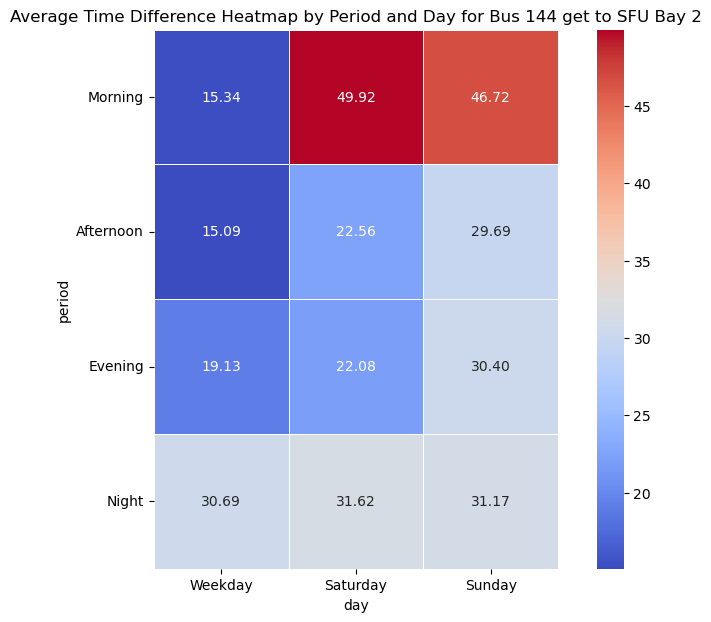

In [14]:
main()